# Testing the optimization run for convergence

In [7]:
import os
import tarfile
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rcParams
import seaborn as sns
import pandas as pd
import numpy as np

from pymoo.indicators.hv import Hypervolume
from pymoo.factory import get_problem

# from pymoo.factory import (
#     get_performance_indicator,
# )  # Used to calculate hypervolume from archivelogged solutions

In [8]:
# sns.set(font_scale=1.2)

fm.fontManager.addfont("Minion Pro Regular.ttf")
matplotlib.rc("font", family="Minion Pro")

rcParams["font.family"] = "Minion Pro"
rcParams["font.sans-serif"] = "Minion Pro"
rcParams["font.size"] = 12

## 1. Data colleciton

### 1.1 Epsilon progress

In [11]:
# Epsilon progress and archivelogs are already saved during the optimization
# Define the subfoldername of the experiment of interest
subfoldername = "nfe5000_uwf_big"
subfolderpath = f"../outputs/{subfoldername}"  

In [12]:
# Create the file path for the convergence CSV file
convergence_filepath = f"{subfolderpath}/baseline_convergence_{subfoldername}.csv"

### 1.2 Hypervolume

In [21]:
# Intermediate results are archived in the 'archive.tar.gz' file which needs to be unpacked
archive_directory = f"{subfolderpath}/archive_logs/tmp"
archive_log_directory = f"{subfolderpath}/archive_logs"

In [22]:
def check_for_csv_files(log_directory):
    csv_files = [file for file in os.listdir(log_directory) if file.endswith('.csv')]
    return len(csv_files) > 0

def extract_and_save_csv_from_tar_gz(log_directory):
    tar_gz_file_path = f"{log_directory}/archives.tar.gz"

    if not os.path.exists(tar_gz_file_path):
        print(f"The file '{tar_gz_file_path}' does not exist.")
        return

    if check_for_csv_files(log_directory):
        print("CSV files already exist in the directory.")
    else:
        with tarfile.open(tar_gz_file_path, "r:gz") as tar:
            tar.extractall(path=log_directory)

        csv_files = [file for file in os.listdir(log_directory) if file.endswith('.csv')]
        if not csv_files:
            print("No CSV files found in the archive.")
        else:
            print(f"CSV files saved: {len(csv_files)}")


In [23]:
extract_and_save_csv_from_tar_gz(log_directory=archive_log_directory)

The file '../outputs/nfe5000_pwf/archive_logs/tmp/archives.tar.gz' does not exist.


## 2 Convergence resultst

### 2.1 Epsilon progress

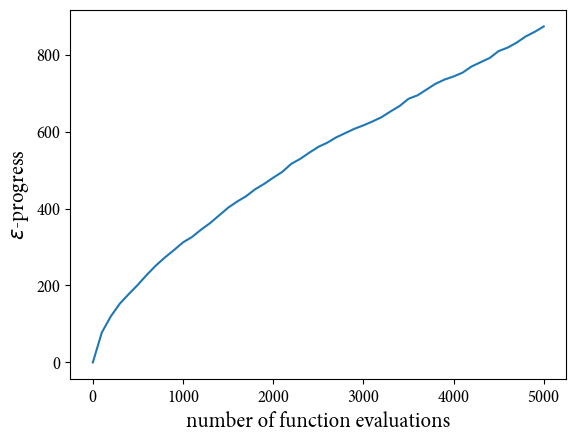

In [24]:
# Read the CSV file into the convergence DataFrame
convergence = pd.read_csv(convergence_filepath)

fig, ax = plt.subplots()
ax.set_xlabel("number of function evaluations", fontsize=15)
ax.set_ylabel("$\epsilon$-progress", fontsize=15)
ax.plot(convergence.nfe, convergence.epsilon_progress)
plt.show()

## Hypervolume:

Let's find the best and worst possible results for all objectives (to normalize them within 0-1 interval) except Sudan's 90th percentile worst month (as it is always 0). I will determine the best and worst possible values for each objective among all the archivelogged sets as well as the final pareto-front:

In [25]:
for name in os.listdir(subfolderpath):
    print(name)

archive_logs
baseline_convergence_nfe5000_uwf_big.csv
baseline_results_nfe5000_uwf_big.csv
time_counter_uwf_big.txt


In [26]:
# if the tar file exists, unpack it

archive_log_dir = subfolderpath+ "/archive_logs"
if not os.path.exists(archive_directory):
    try: 
        tar_file_path = archive_log_dir + "/archives.tar.gz"
        print(tar_file_path)
         # Extract the tar.gz file
        with tarfile.open(tar_file_path, 'r:gz') as tar:
            try: 
                tar.extractall(path=archive_log_dir)
                print("unpacked tarfile to tmp folder")
            except Exception as e:
                print("opended tarfile but could not extract")
    except Exception as e: 
        print("could not unpack tar file to folder")

num_files = len([name for name in os.listdir(archive_directory) if os.path.isfile(os.path.join(archive_directory, name))])
print(num_files)

51


In [27]:
print(convergence_filepath)

../outputs/nfe5000_uwf_big/baseline_convergence_nfe5000_uwf_big.csv


In [28]:
obj_indexes = [-6, -5, -4, -3, -2, -1]  # To get rid of Sudan objectives
directions = [
    "min",
    "min",
    "min",
    "min",
    "min",
    "max",
]  # Only GERD Hydropower is a maximization objective 
best = [
    1e9,
    1e9,
    1e9,
    1e9,
    1e9,
    0,
]  # Initialize the set of best values with really bad results (the aim is to reach the real best with the for loop)
worst = [0, 0, 0, 0, 0, 1e10]  # Same idea, initialize the worst as something very good

# csvs_to_read = [f"../outputs/{subfoldername}/archive_logs/archive_{i}.csv" for i in range(2, 75)]
# csvs_to_read = [f"../outputs/nfe10000_archive_test/archive_logs/tmp/archive_{i}.csv" for i in range(2, 75)]

file_names = [name for name in os.listdir(archive_directory) if os.path.isfile(os.path.join(archive_directory, name))]
csvs_to_read = [f"{archive_directory}/{file_names[i]}" for i in range(1, len(file_names))]
csvs_to_read.append(f"{subfolderpath}/baseline_results_{subfoldername}.csv")  # All archived solutions + final set

In [29]:
for file in csvs_to_read:
    print(pd.read_csv(file).shape)
    current_df = pd.read_csv(file).iloc[:, obj_indexes]
    for i, col in enumerate(current_df.columns):
        # Updating the bests and worsts by looking at each solution:
        if directions[i] == "min":
            if current_df[col].max() > worst[i]:
                worst[i] = current_df[col].max()
            if current_df[col].min() < best[i]:
                best[i] = current_df[col].min()
        if directions[i] == "max":
            if current_df[col].max() > best[i]:
                best[i] = current_df[col].max()
            if current_df[col].min() < worst[i]:
                worst[i] = current_df[col].min()

(67, 172)
(204, 172)
(214, 172)
(229, 172)
(243, 172)
(251, 172)
(269, 172)
(282, 172)
(286, 172)
(297, 172)
(304, 172)
(102, 172)
(318, 172)
(328, 172)
(335, 172)
(346, 172)
(331, 172)
(331, 172)
(340, 172)
(342, 172)
(349, 172)
(349, 172)
(128, 172)
(357, 172)
(345, 172)
(355, 172)
(366, 172)
(380, 172)
(396, 172)
(405, 172)
(417, 172)
(419, 172)
(430, 172)
(149, 172)
(438, 172)
(440, 172)
(450, 172)
(460, 172)
(468, 172)
(468, 172)
(469, 172)
(477, 172)
(482, 172)
(481, 172)
(166, 172)
(491, 172)
(192, 172)
(194, 172)
(199, 172)
(189, 172)
(491, 172)


In [30]:
print(best)
print(worst)

[1.1499700059423024, 0.0, 6.042762711369737, 1.2944300877764328, 2.146035983070017, 954223.578201025]
[8.514625742759206, 0.9541666666666668, 11.707762013691225, 1.9402569669057173, 15.128897579855227, 22.31628672661931]


In [31]:
# Normalize objectives function makes the best outcome 1, worst 0 for each obj value
def normalize_objs(df, worst, best):
    for i, col in enumerate(df.columns):
        df[col] = (best[i] - df[col]) / (best[i] - worst[i])

    return np.array(df)

In [32]:
from tqdm import tqdm

# Let's calculate hypervolume per NFE to plot
hvs = np.empty(0)
nfes = np.empty(0)
hv = Hypervolume(
    ref_point=np.array([1.2, 1.2, 1.2, 1.2, 1.2, 1.2])
) # Reference set, works fine since everything is btwn 0-1

for i in tqdm(
    range(1, num_files)
):  # We have that 82 archive logs, first doesn't have a solution
    if i <= 20:
        nfes = np.append(nfes, 100 * i)  # Convergence check frequency is 500 NFEs
    else:
        if i > 20 and i <= 25:
            nfes = np.append(nfes, 10000 + (i - 20) * (714.4))
        if i > 25:
            nfes = np.append(nfes, 13572 + (i - 25) * (752))

    # # print(i, "I am here NFE")
    # hvs = np.append(
    #     hvs,
    #     (
    #         hv.do(
    #             normalize_objs(  # Read and normalize data frames with 5 objectives
    #                 pd.read_csv(f"../outputs/{subfoldername}/archive_logs/tmp/{file_names[i]}.csv").iloc[
    #                     :, obj_indexes
    #                 ],
    #                 worst,
    #                 best,
    #             )
    #         )
    #     ),
    # )

    df = pd.read_csv(f"../outputs/{subfoldername}/archive_logs/tmp/{file_names[i]}").iloc[:, obj_indexes]
    normalized_objs = normalize_objs(df, worst, best)
    hv_value = hv.do(normalized_objs)
    hvs = np.append(hvs, hv_value)
    # print(i, "I am here HV")

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [2:03:10<00:00, 147.80s/it]  


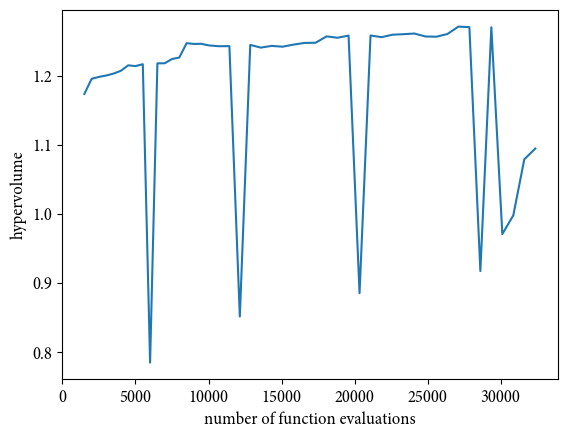

In [33]:
fig, ax = plt.subplots()
ax.set_xlabel("number of function evaluations")
ax.set_ylabel("hypervolume")
ax.plot(
    nfes[2:], hvs[2:]
)  # First 6 distorts the view, giving a wrong sense of convergence
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../plots/convergence_nfe5000_pwf.svg'

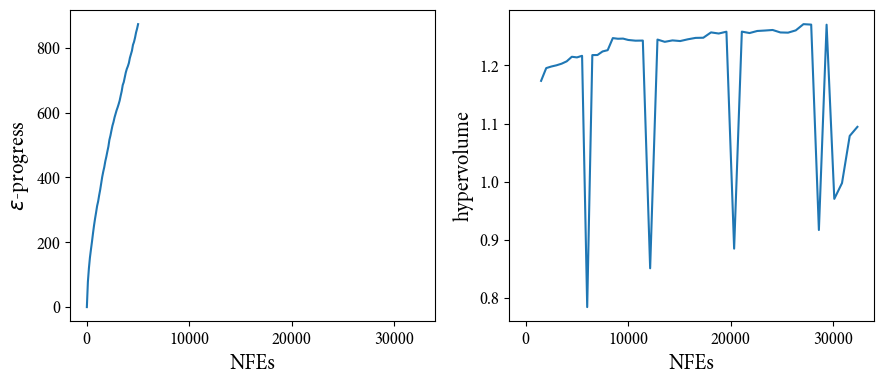

In [34]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(9, 4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel("$\epsilon$-progress", fontsize=15)
ax2.plot(nfes[2:], hvs[2:])
ax2.set_ylabel("hypervolume", fontsize=15)

ax1.set_xlabel("NFEs", fontsize=15)
ax2.set_xlabel("NFEs", fontsize=15)
fig.tight_layout()
# plt.grid(False)
plt.savefig(f"../plots/convergence_{subfoldername}.svg")
plt.show()

Interestingly epsilon progress suggests there is room for improvement however hypervolume hints at the opposite with **50,000** NFEs!